In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

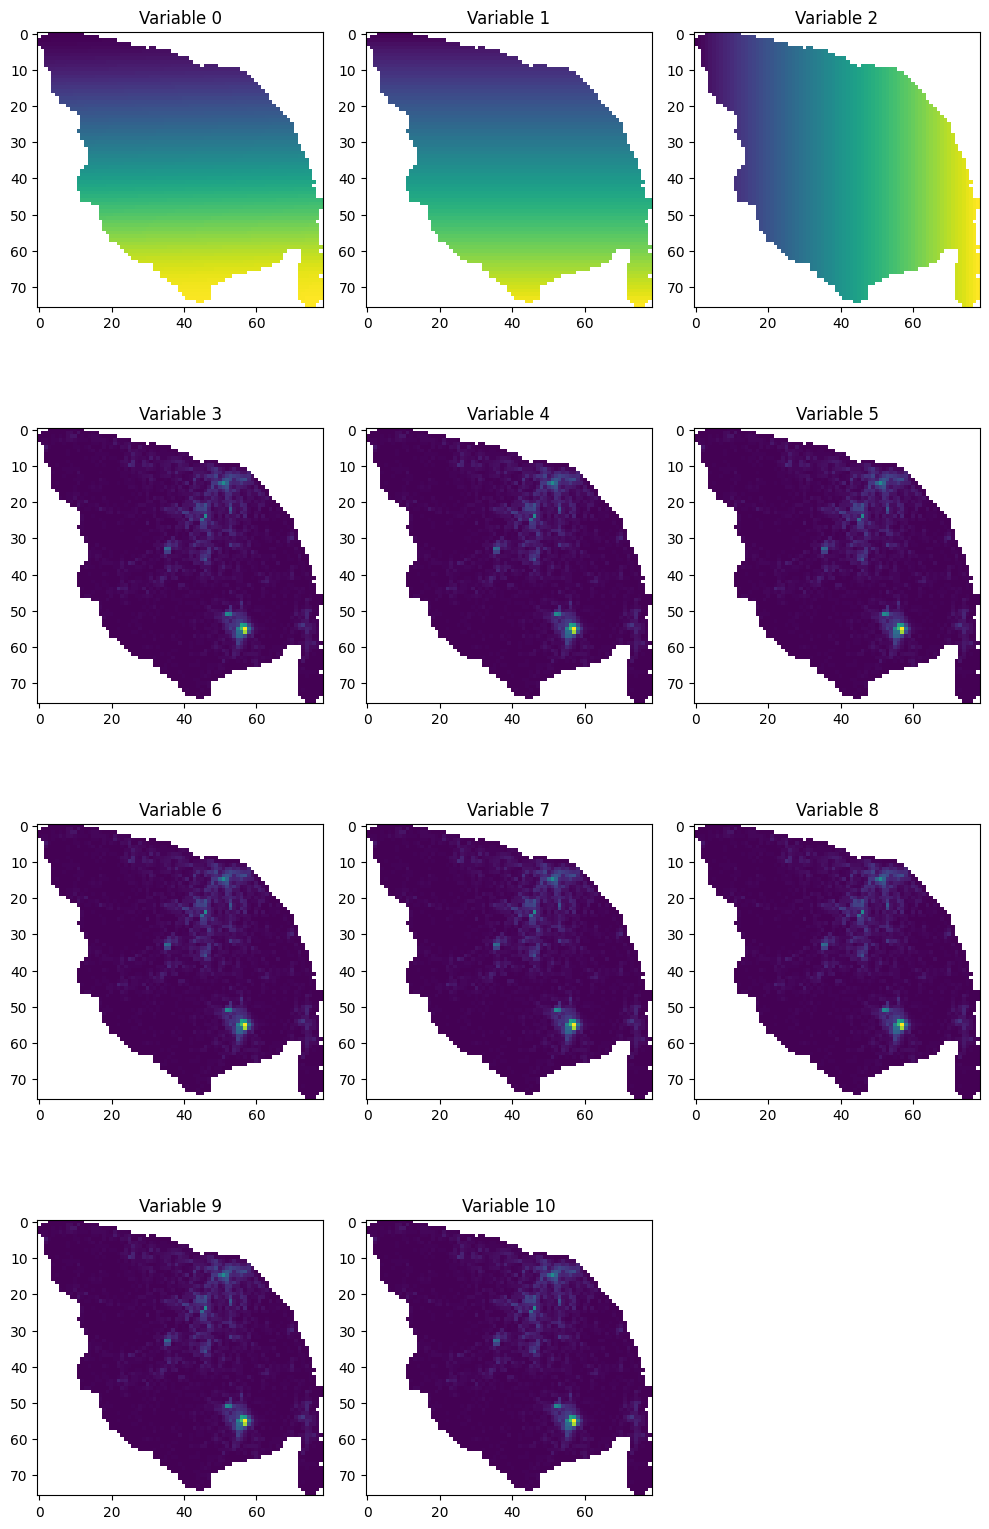

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

In [4]:
cell_ids = data[...,0,0]
relevant_cells_mask = ~np.isnan(cell_ids)

Model definition and train

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    # define LSTM model
    model.add(LSTM(units=25))
    # Final output - prediction for t+1 for each cell ID
    model.add(Dense(output_shape))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

2023-04-17 20:53:59.073234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 20:53:59.366838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 20:53:59.368179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 20:54:00.732655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# Setting the timestep dim as the first dimensions
data = np.transpose(data, (2, 0, 1, 3))
print(f'Whole dataset shape: {data.shape}')

Whole dataset shape: (8736, 76, 79, 11)


In [21]:
# Using only the C's data
x_data = data[...,3:]
x_data[np.isnan(x_data)] = 0

print(x_data.shape)

x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
x_data_val_and_test = x_data[int(x_data.shape[0]*2/3):,...] 


(8736, 76, 79, 8)


In [14]:
# number of 15 min chuncks in 1 h
n_in_24h = 24*4
# number of input timestep + 1 (1 output timestep)
window_size = n_in_24h + 1
# 1h shift for now, it can be increase to take full advantage of the data
shift = 4 
batch_size = 32
shuffle_buffer = 32

def windowed_dataset(data, window_size, batch_size, shuffle_buffer):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # This is providing C1 as the output, but maybe we want C1 + C2 ... 
    dataset = dataset.map(lambda window: (window[:-1], window[-1,:,:,0][relevant_cells_mask]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


dataset = windowed_dataset(x_data_train, window_size, batch_size, shuffle_buffer)

In [15]:
# Can be used to visualize the dataset shapes 
times = 0
for x,y in dataset:
    print(x.numpy().shape)
    print(y.numpy().shape)
    times += 1
    if times > 4:
        break

2023-04-17 20:56:24.896214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-17 20:56:24.896480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]


(32, 96, 76, 79, 8)
(32, 3743)
(32, 96, 76, 79, 8)
(32, 3743)
(32, 96, 76, 79, 8)
(32, 3743)
(32, 96, 76, 79, 8)
(32, 3743)
(32, 96, 76, 79, 8)
(32, 3743)


In [16]:
input_shape = (None,96,76,79,8)
output_shape = relevant_cells_mask.sum()
model =CNN_LSTM(input_shape, output_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 96, 76, 79, 4)    132       
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 96, 38, 39, 1)    17        
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 96, 19, 19, 1)    0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 96, 361)         

2023-04-17 20:56:36.387753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 20:56:36.389917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 20:56:36.391023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
history = model.fit(dataset, epochs=100)

Epoch 1/100


2023-04-17 20:56:38.091828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 20:56:38.094058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-17 20:56:38.095271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 97s 2s/step - loss: 539.6805
Epoch 2/100
45/45 [==============================] - 95s 2s/step - loss: 473.2898
Epoch 3/100
45/45 [==============================] - 97s 2s/step - loss: 429.9982
Epoch 4/100
45/45 [==============================] - 91s 2s/step - loss: 397.8484
Epoch 5/100
45/45 [==============================] - 94s 2s/step - loss: 372.5952
Epoch 6/100
45/45 [==============================] - 92s 2s/step - loss: 352.1019
Epoch 7/100
45/45 [==============================] - 78s 2s/step - loss: 335.1152
Epoch 8/100
45/45 [==============================] - 78s 2s/step - loss: 320.8295
Epoch 9/100
45/45 [==============================] - 79s 2s/step - loss: 308.6900
Epoch 10/100
45/45 [==============================] - 76s 2s/step - loss: 298.2941
Epoch 11/100
45/45 [==============================] - 75s 2s/step - loss: 289.3376
Epoch 12/100
45/45 [==============================] - 77s 2s/step - loss: 281.5835
Epoch 13/100
45/45 [=====

KeyboardInterrupt: 

In [18]:
# QUESTION: Use the model in a recursive way? 


# list all data in history
print(history.history.keys())

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [34]:
# Model prediction

pred = model(x_data_val_and_test[np.newaxis,0:n_in_24h,...]).numpy()
ground_truth =x_data_val_and_test[n_in_24h,...,0][relevant_cells_mask]


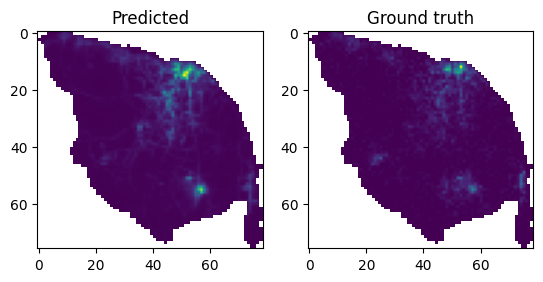

In [35]:
import pandas as pd 

grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")


# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
pred_2d = grelha_id_2d.copy()
ground_truth_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
pred_2d[tuple(idx_2d)] = pred.ravel()
ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()


fig, axs = plt.subplots(1,2)

axs[0].set_title('Predicted')
axs[0].imshow(pred_2d)

axs[1].set_title('Ground truth')
axs[1].imshow(ground_truth_2d)

# axs[2].set_title('Error (%)')
# axs[2].imshow((pred_2d-ground_truth_2d)/(ground_truth_2d))

In [36]:
from sklearn.metrics import mean_squared_error
from scipy import stats

truth_stats = stats.describe(ground_truth.flatten())
pred_stats = stats.describe(pred.flatten())

print("RESULTS")
print("MSE:", mean_squared_error(ground_truth, pred))
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)

ModuleNotFoundError: No module named 'sklearn'

NameError: name 'truth_stats' is not defined

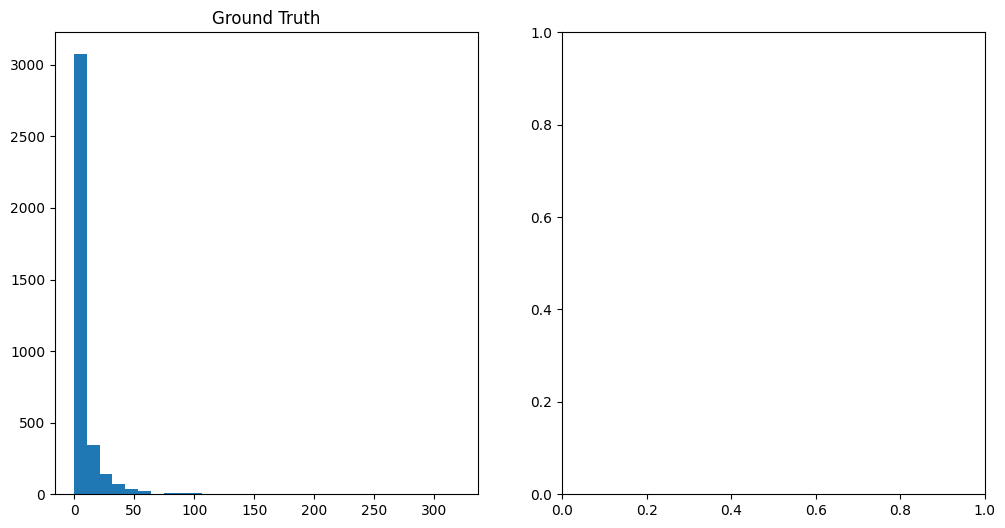

In [37]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ground_truth.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(pred.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()